Le but de ce notebook est de reprendre la première partie relative au traitement des données energétique et d’enchainer sur la prédiction de la consommation d’énergies en utilisant Long Short Term Memory (LSTM).
Pour cela plusieurs fonctions devront être définis.

Commencer par importer les différentes librairies pour traiter les données(pandas), tracer les graphes(matplotlib), effectuer la normalisation(sklearn.preprocessing), stocker et manipuler des données(numpy) et la librairie de deep learning(tensorflow).

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sys


#### 1. Traitement des données
#### 1.1 Chargement des données sous forme csv
utiliser les champs:  'Date and time (UTC)', 'Air Temperature (ÂºC)', 'Total electricity consumption (kW)',
       'Zone1 electricity consumption (kW)',
       'Zone2 electricity consumption (kW)' à partir du fichier 6mois.csv
 
Utiliser les attributs usecols, index_col=0 et parse_dates=True

In [12]:
df = pd.read_csv('6mois.csv', usecols=[0, 1,6,7,8], index_col=0, parse_dates=True)

#### 1.2 Réechantillonnage toute les 15 minutes

In [13]:
df = df.resample('15Min').mean()

#### 1.3 Extraction des informations relatives à la date
A partir de la date (colonne 0 du dataframe), nous créons les nouveaux features : day of the week, day of the year, hour of the day , etc. 

In [14]:
df['day of the week'] = df.index.dayofweek 
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['number of the week'] = df.index.weekofyear
df['minute of the hour'] = df.index.minute

#### 1.4 Selection des features et des labels

Après avoir charger et modifier les données, séléctionner les features et les labels.
Ils existent plusieurs type de prediction:
- One to One
- One to Many
- Many to One
- Many to Many

Dans ce qui suit nous allons nous intérésser au cas many to one.

Nous aurons dans le label Total electricity consumption (kW) et dans les features 'day of the week', 'hour of the day', 'minute of the hour', 'Air Temperature (ºC)', 'number of the week'
Il faut par la suite concatener les features et les labels dans input 

In [19]:
features = ['day of the week', 'hour of the day', 'minute of the hour', 'Air Temperature (ºC)', 'number of the week']
labels   = ['Total electricity consumption (kW)']
# re-concatener les features et les labels dans inputs
inputs   =  features + labels
df = df[inputs] 

# Créer un nouveaux dataframe avec les donnée shifté
shift_days = 1
shift_steps = shift_days
df_targets = np.roll(df[labels],-shift_steps)

#### 1.5 Effectuer la normalisation des données en utilisant MinMaxScaler()

In [34]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index) 

#### 1.6 Afficher la consommation totale du batiment dans un graphe

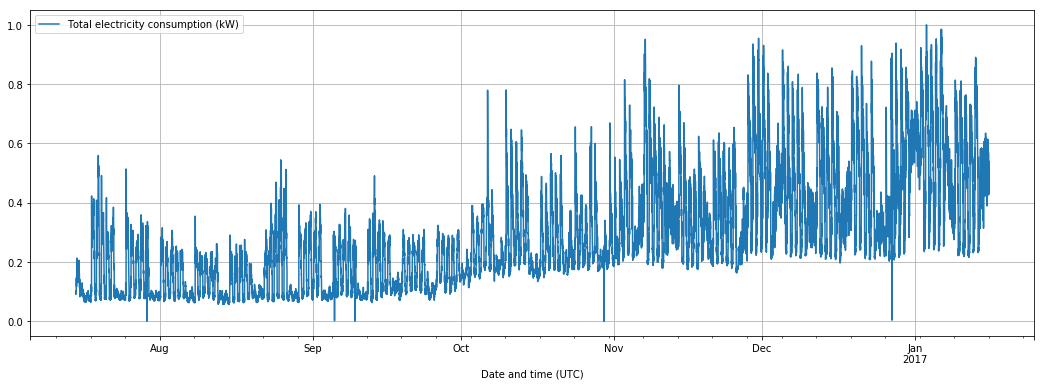

In [35]:
# Afficher le Label
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
df_scaled[labels].plot(ax=ax)
plt.grid(True)
plt.show()

#### 1.7 Crétion des données d'apprentissage et de test
Créer la fonction split_data qui prends en entrée les donnée et la taille des données de test.
et  qui retourne deux dataframe (df_train et df_test)

In [36]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest =  int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test


Créer df_train, df_test en utilisant la fonction split_data

Par la suite définissez
- x_train_scaled
- x_test_scaled
- y_test_scaled
- y_train_scaled

Finalement afficher la longeur totale des données, la longeur des données d'apprentissage et  la longeurs des données de tests.

In [37]:
# Utiliserla fonction split_data
df_train, df_test = split_data(df_scaled, test_size=0.25)

# Créer les arrays suivants
x_train_scaled = np.asarray(df_train[features])
x_test_scaled = np.asarray(df_test[features])
y_test_scaled = np.asarray(df_test[labels])
y_train_scaled = np.asarray(df_train[labels])

num_test = len(df_test)
num_train = len(df_train)
num_total = len(df)

print(f'Longueur totale des données: \t\t\t{len(df)}\n' + f'Longueur totale des données de test: \t\t{len(df_test)}\n' +
     f'Longueur totale des données d"apprentissage: \t{len(df_train)}\n')


Longueur totale des données: 			17761
Longueur totale des données de test: 		4440
Longueur totale des données d"apprentissage: 	13321



#### 1.8 Afficher dans un graphe les données d'apprentissage et les données de test

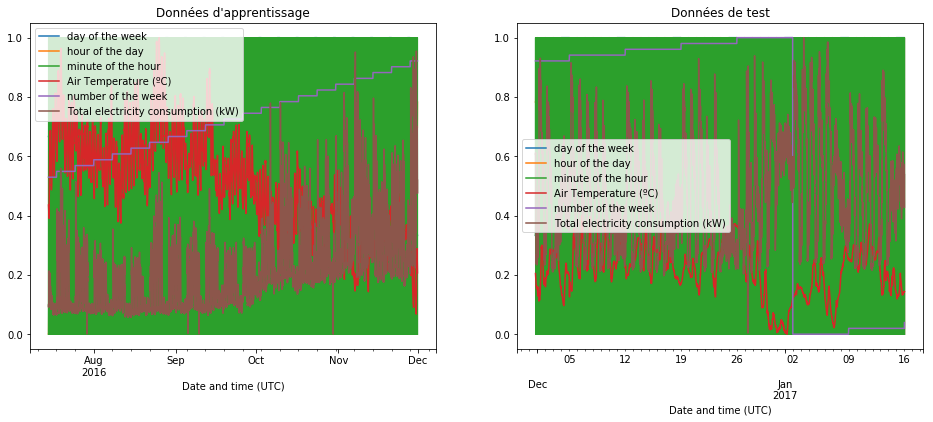

In [38]:

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_train.plot(ax=ax1, title="Données d'apprentissage")
df_test.plot(ax=ax2, title="Données de test")

Afficher les informations des tailles de :
- num_features
- num_labels 
- num_inputs

In [39]:
num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

print(f'Longueur totale des données: \t\t\t{num_features}\n' + f'Longueur totale des données de test: \t\t{num_labels}\n' +
     f'Longueur totale des données d"apprentissage: \t{num_inputs}\n')

Longueur totale des données: 			5
Longueur totale des données de test: 		1
Longueur totale des données d"apprentissage: 	6



#### 1.9 Fonction pour la création des batch aléatoire pour les données d'apprentissage et de test 


In [40]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
   
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


#### 1.10 Creation de la matrice Batch, de taille batch_size x sequence_lenth x num_inputs

C'est à dire une matrice qui contient batch_size échantillons de taille sequence_lenth, par exemple 2 jours, et ce pour toute les entrés (jour de la semaine, heure du jour, etc.).

X Batch Shape :  (50, 96, 5)
Y Batch Shape :  (50, 96, 5)


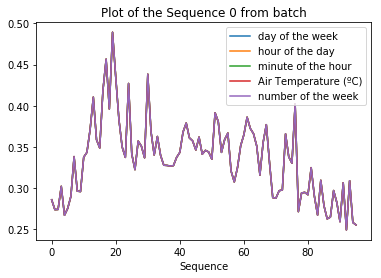

In [49]:
batch_size = 50         
sequence_length =  int(60/15*24*1)

generator     = batch_generator(batch_size, sequence_length, num_features, num_labels, num_train, y_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_train, y_train_scaled, y_train_scaled)

x_batch, y_batch = next(generator)

print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')

seq = x_batch[0, :, :]
plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the Sequence 0 from batch')
plt.show()

## 2. Création du modèle de prédiction

On choisis ici un modèle de type _dynamique recurrent neural network_ (dynamic_rnn). Avec _num layer_ cellules de type LTSM et une couche dense. La fonction d'optimisation étant _tf.losses.mse_, i.e. the mean square error. 

In [50]:
from tensorflow.keras.utils import Progbar
# Un réseaux de neuronnes avec les caractériqtiques suivantes num_neurons = 100, learning_rate = 0.001, num_layers = 4, num_iter = 500, keep_prob = 0.2
num_neurons = 100
learning_rate = 0.001
num_layers = 4
num_iter = 500
keep_prob = 0.2
# Vous pouvez changer les caractéristiques du reseaux de neuronnes et observer leur impacts sur les prédictions
next(testgenerator)
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name="x")
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 

    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
  
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])

    
    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    # from another program 
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)        #specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels])          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
        
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch})   
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
                            
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})
        
        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})
        

499/500 [============================>.] - ETA: 0s - MSE: 0.0024

## 3. Inverse transformation and plot prediction on test data

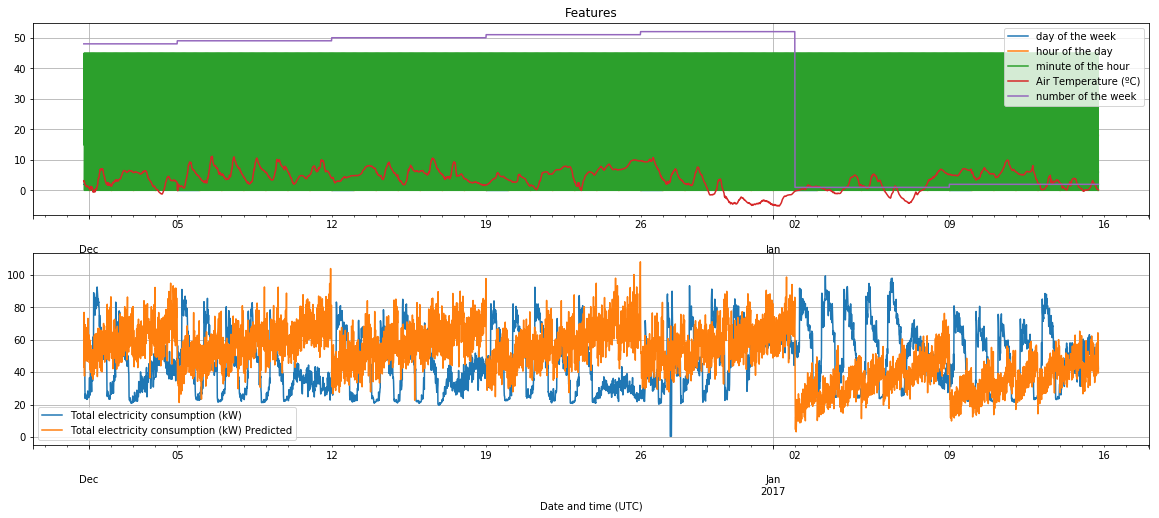

In [51]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=df_test.iloc[0:ind].index, columns=labels)

fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(311)
df[features].loc[DF.index].plot(ax=ax)
plt.grid()
plt.title('Features')

ax = fig.add_subplot(312)
df[labels[0]].loc[DF.index].plot(ax=ax)
DF[labels[0]].plot(ax=ax, label=labels[0]+' Predicted')
plt.legend()
plt.grid()


## 4. Mesure de performance
Calculer le MSE global et le RMSE global.

In [52]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.000
RMSE : 0.021


## 5. Modification de la fenêtre de prédiction 
Au nuiveau de l'étape 1.4 nous avons définis le shift_steps qui correspond au  nombres de valeurs que nous voulons prédire comme nous avons un pas de 15min nous allons prédire les prochaine 15min
- Changer ce paramètre pour prédire les 6 prochaines heures puis le jour suivant.
- Refaire la phase d'apprentissage.
- Comparer le MSE et le RMSE pour chaque shift step